In [2]:
import numpy as np
import scipy.special

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import pystan

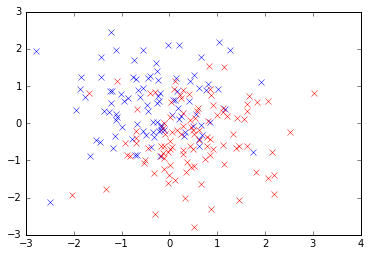

In [32]:
np.random.seed(1)
N = 200
x = np.random.multivariate_normal([0, 0], np.identity(2), size=N)

beta  = np.array([1, -1])
alpha = 0
p = scipy.special.expit(x.dot(beta) + alpha)
r = np.random.uniform(size=N)
category = r < p
x0 = x[np.logical_not(category)]
x1 = x[category]
y = np.array(category, dtype="int")

plt.plot(x0[:,0], x0[:,1], 'bx');
plt.plot(x1[:,0], x1[:,1], 'rx');

In [33]:
import pystan
model_code = """
data {
    int<lower=0> N;
    int<lower=1> D;

    int<lower=0, upper=1> y[N];
    vector[D] x[N];
}

parameters {
    matrix[1,D] beta;
    real alpha;
}

model {
    to_vector(beta) ~ normal(0, 5);
    alpha ~ normal(0, 5);

    for (n in 1:N)
        y[n] ~ bernoulli_logit(beta * x[n] + alpha);
}
"""
model = pystan.StanModel(model_code=model_code)

In [34]:
fit = model.sampling(data=dict(N=N, D=2, x=x, y=y))

In [35]:
print fit

Inference for Stan model: anon_model_b81c86a687567183c11432f471aeeb31.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]   1.34  7.6e-3   0.25   0.89   1.17   1.34    1.5   1.84 1040.0    1.0
beta[0,1]  -1.42  7.5e-3   0.24   -1.9  -1.58  -1.41  -1.25  -0.95 1055.0    1.0
alpha       0.12  5.4e-3   0.18  -0.23-5.2e-3   0.12   0.23   0.46 1070.0    1.0
lp__      -96.32    0.04   1.23 -99.56 -96.87  -96.0 -95.41  -94.9  751.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Mar  2 16:55:50 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


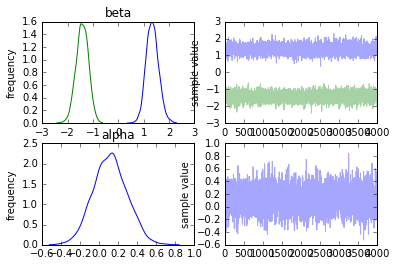

In [36]:
fit.plot();

In [37]:
samples = fit.extract()

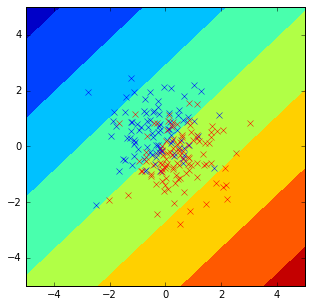

In [38]:
alpha = samples['alpha']
beta  = samples['beta'].reshape(-1,2)

f, ax = plt.subplots(1, 1, figsize=(5, 5))

def logistic_plot(alpha, beta, ax=plt):
    xx = np.linspace(-5, 5)
    yy = np.linspace(-5, 5)
    xv, yv = np.meshgrid(xx, yy)

    nu = (beta[0] * xv) + (beta[1] * yv) + alpha
    z = 1 / (1 + np.exp(-nu))

    ax.plot(x0[:,0], x0[:,1], 'bx')
    ax.plot(x1[:,0], x1[:,1], 'rx')
    ax.contourf(xx, yy, nu)

logistic_plot(alpha.mean(), beta.mean(axis=0))

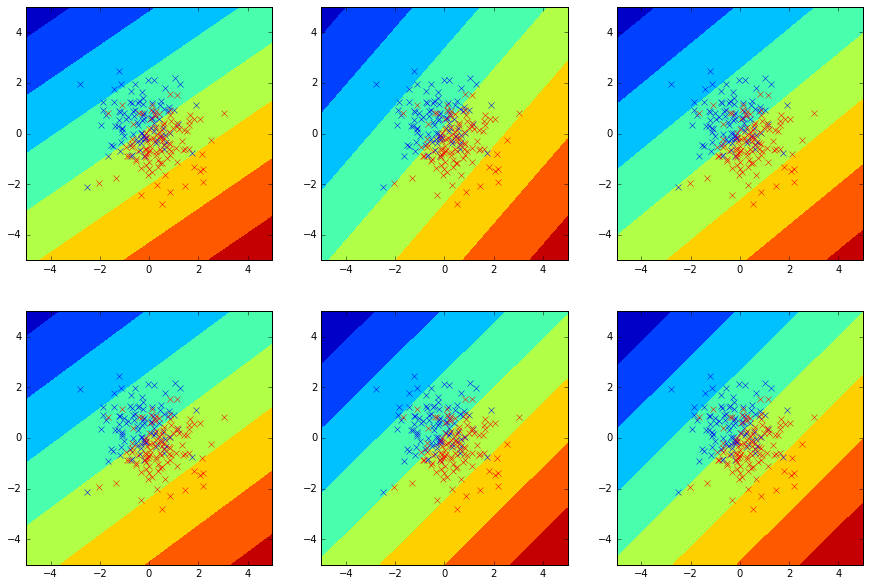

In [39]:
f, axs = plt.subplots(2, 3, figsize=(15,10))

for ax in axs.flatten():
    n = np.random.randint(len(alpha))
    alpha_p = alpha[n]
    beta_p  = beta[n]
    logistic_plot(alpha_p, beta_p, ax=ax)